In [1]:
import pdal
import json
import geopandas
import pandas as pd
from shapely.geometry import Polygon, Point, mapping
import numpy as np
from pyproj import Proj, transform
import folium
import laspy as lp
import richdem as rd
import rasterio
import math
import urllib.request, json 
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
# loading json file
def read_json(json_path):
    try:
        with open(json_path) as js:
            json_obj = json.load(js)
        return json_obj

    except FileNotFoundError:
        print('File not found.')


In [3]:


def convert_EPSG(fromT, toT, lon, lat):
    input1 = Proj(init=f'epsg:{fromT}')
    input2 = Proj(init=f'epsg:{toT}') 
    x, y = transform(input1,input2, lon, lat)
    return [x, y]
    
def loop_EPSG_converter(listin, fromT, toT):
    converted = []
    for item in listin:
        converted.append(convert_EPSG(fromT, toT, item[0], item[1]))
        
    return converted

In [4]:
def generate_polygon(coor, epsg):
    polygon_g = Polygon(coor)
    crs = {'init': 'epsg:'+str(epsg)}
    polygon = geopandas.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_g])       
    return polygon

In [5]:
def generate_geo_df(points, epsg):
    try:
        cloud_points = []
        elevations =[]
        geometry_points=[]
        for row in points:
            try:
                lst = row.tolist()[-3:]
            except:
                lst = row.tolist()
            cloud_points.append(lst)
            elevations.append(lst[2])
            point = Point(lst[0], lst[1])
            geometry_points.append(point)
        geodf = geopandas.GeoDataFrame(columns=["elevation", "geometry"])
        geodf['elevation'] = elevations
        geodf['geometry'] = geometry_points
        geodf = geodf.set_geometry("geometry")
        geodf.set_crs(epsg = epsg, inplace=True)
        return geodf
    except RuntimeError as e:
        self.logger.exception('fails to extract geo data frame')
        print(e)

In [6]:
coordinates = [
    [-93.756055, 41.916115],
    [-93.757155, 41.917215],
    [-93.758396, 41.918475],
    [-93.757955, 41.917300],
    [-93.754795, 41.914000],
]

In [7]:
polygon2 = generate_polygon(coordinates, 4326)

In [8]:
polygon2

geometry
0  POLYGON ((-93.75606 41.91611, -93.75715 41.917...

In [9]:

def show_on_map(polygon, zoom):
    #region selection
    poly = mapping((polygon2.iloc[:,0][0]))
    tmp = poly['coordinates'][0][0]
    anchor = [tmp[1], tmp[0]]
    m = folium.Map(anchor,zoom_start=zoom, tiles='cartodbpositron')
    folium.GeoJson(polygon).add_to(m)
    folium.LatLngPopup().add_to(m)
    return m

show_on_map(polygon2, 15)

In [82]:
coor = loop_EPSG_converter(coordinates, 4326, 3857)
print(coor)
polygon_i = generate_polygon(coor, 3857)
type(polygon_i)

[[-10436876.301386151, 5148721.349314567], [-10436887.43333523, 5148736.309605352], [-10436914.26133251, 5148775.206471106], [-10436865.169437071, 5148749.025870951], [-10436847.358318545, 5148704.145009145]]


geopandas.geodataframe.GeoDataFrame

In [166]:

def modify_pipe_json(json_loc, url, in_epsg, out_epsg, polygon_b, bounds=None):
    dicti = read_json(json_loc)
    if bounds is not None:
        dicti['pipeline'][0]['bounds'] = f"([{bounds[0]},{bounds[2]}],[{bounds[1]},{bounds[3]}])"
    dicti['pipeline'][0]['polygon'] = str(polygon_b.iloc[:,0][0])
    dicti['pipeline'][0]['filename'] = url
    dicti['pipeline'][2]['in_srs'] = f"EPSG:{in_epsg}"
    dicti['pipeline'][2]['out_srs'] = f"EPSG:{out_epsg}"
    return dicti
    
location = "pdal.json"
url = "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/IA_FullState/ept.json"
region = "IA_FullState"
in_srs = 3857
out_srs = 4326

request = modify_pipe_json(location, url, in_srs, out_srs, polygon_i)


{'pipeline': [{'polygon': 'POLYGON ((-10436876.301386151 5148721.349314567, -10436887.43333523 5148736.309605352, -10436914.26133251 5148775.206471106, -10436865.169437071 5148749.025870951, -10436847.358318545 5148704.145009145, -10436876.301386151 5148721.349314567))', 'filename': 'https://s3-us-west-2.amazonaws.com/usgs-lidar-public/IA_FullState/ept.json', 'type': 'readers.ept', 'tag': 'readdata'}, {'type': 'filters.range', 'limits': 'Classification[2:2]'}, {'in_srs': 'EPSG:3857', 'out_srs': 'EPSG:4326', 'tag': 'reprojectUTM', 'type': 'filters.reprojection'}, {'filename': 'iowa.csv', 'tag': 'writerscsv', 'type': 'writers.text'}, {'filename': 'iowa.las', 'tag': 'writersply', 'type': 'writers.las'}, {'filename': 'dem.tif', 'gdaldriver': 'GTiff', 'output_type': 'all', 'resolution': '1.0', 'type': 'writers.gdal'}]}


In [146]:

pipe = pdal.Pipeline(json.dumps(request))
json.dumps(request)

'{"pipeline": [{"polygon": "POLYGON ((-10436876.301386151 5148721.349314567, -10436887.43333523 5148736.309605352, -10436914.26133251 5148775.206471106, -10436865.169437071 5148749.025870951, -10436847.358318545 5148704.145009145, -10436876.301386151 5148721.349314567))", "filename": "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/IA_FullState/ept.json", "type": "readers.ept", "tag": "readdata"}, {"type": "filters.range", "limits": "Classification[2:2]"}, {"in_srs": "EPSG:3857", "out_srs": "EPSG:4326", "tag": "reprojectUTM", "type": "filters.reprojection"}, {"filename": "iowa.csv", "tag": "writerscsv", "type": "writers.text"}, {"filename": "iowa.las", "tag": "writersply", "type": "writers.las"}, {"filename": "dem.tif", "gdaldriver": "GTiff", "output_type": "all", "resolution": "1.0", "type": "writers.gdal"}]}'

In [147]:
pipe.execute()

472

In [86]:
df = generate_geo_df(pipe.arrays[0], 4326)

In [87]:
def plot_heatmap(df, title) -> None:
    """ Plots a 2D heat map for the point cloud data using matplotlib
    """

    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    df.plot(column='elevation', ax=ax, legend=True, cmap="terrain")
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig('eatmap.png', dpi=120)
    plt.show()

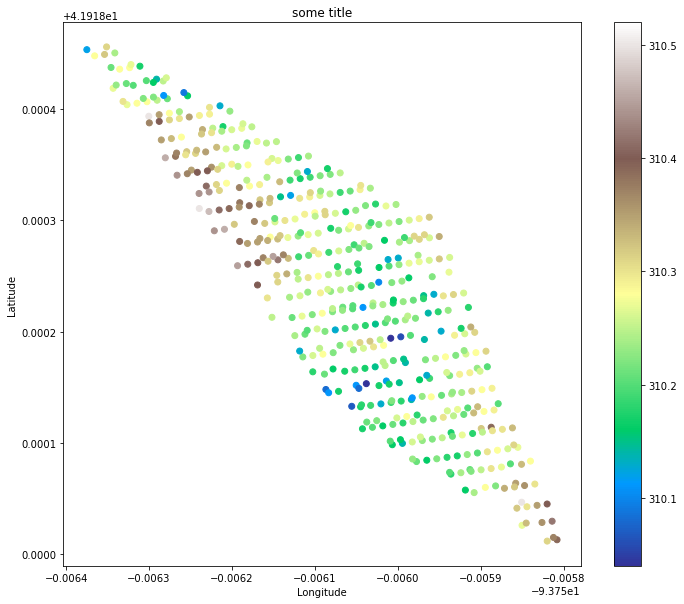

In [88]:
plot_heatmap(df, "some title")

In [35]:
def render_3d(points, s: float = 0.01) -> None:
    """ Plots a 3D terrain scatter plot for the cloud data points of geopandas data frame using matplotlib
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    ax = plt.axes(projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=s)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.savefig('plot3d.png', dpi=120)
    plt.show()

In [36]:
render_3d(points)

NameError: name 'points' is not defined

In [ ]:
import urllib3

In [ ]:
Shttp = urllib3.PoolManager()

In [ ]:
import xml.etree.ElementTree as ET
import urllib.request

url = 'https://s3-us-west-2.amazonaws.com/usgs-lidar-public'
response = urllib.request.urlopen(url).read()
tree = ET.fromstring(response)
f =  open("myxmlfile.xml", "wb")
f.write(response)
f.close()

In [ ]:
import uuid
uuid.uuid1()

In [162]:
dataset = rasterio.open('rster.tif')

array([[         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ..., 310.38565613,
                 nan,          nan],
       ...,
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan]])

In [163]:
data = dataset.read()
data.shape

(1, 445, 569)

In [164]:
data

array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ..., 310.38565613,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]]])

In [165]:
data = np.squeeze(data)
data

array([[         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ..., 310.38565613,
                 nan,          nan],
       ...,
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan]])

In [214]:
sp_dem = rd.rdarray(data, no_data=-9999)
sp_dem

rdarray([[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ..., 310.38565613,
                   nan,          nan],
         ...,
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan]])

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.85155======================== ] (99% - 0.0s - 1 threads)


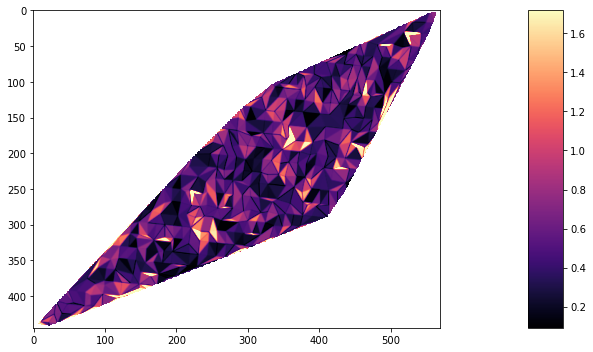

In [215]:
slope = rd.TerrainAttribute(sp_dem, attrib='slope_percentage')
rd.rdShow(slope, axes=True, cmap='magma', figsize=(10, 5))
plt.show()

In [216]:
slope.shape

(445, 569)

In [63]:
df.head()

elevation                    geometry
0     310.37  POINT (-93.75581 41.91802)
1     310.33  POINT (-93.75585 41.91803)
2     310.30  POINT (-93.75584 41.91804)
3     310.40  POINT (-93.75582 41.91805)
4     310.24  POINT (-93.75591 41.91806)

In [133]:
points = list(zip(df.geometry.x, df.geometry.y))
values = df.elevation.values


In [156]:
rRes = 0.000001

xRange = np.arange(df.geometry.x.min(), df.geometry.x.max()+rRes, rRes)
yRange = np.arange(df.geometry.y.min(), df.geometry.y.max()+rRes, rRes)


In [224]:
from scipy.interpolate import griddata
gridX, gridY = np.meshgrid(xRange, yRange)

gridph = griddata(points, values, (gridX,gridY), method='cubic')



array([[         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ..., 310.38526339,
                 nan,          nan],
       ...,
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan]])

In [225]:
gridph.shape

(445, 569)

In [232]:
nonnan = []
for item in gridph:
    for it in item:
        if(it >= 0):
           nonnan.append(it)

In [234]:
nonnan[:5]

[310.3126196136605,
 310.31571980089603,
 310.31948653701414,
 310.32382403317933,
 310.3286717702516]

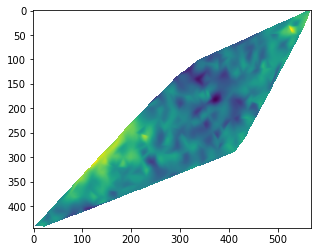

In [223]:
plt.imshow(gridph)

In [159]:
from rasterio.transform import Affine
transform = Affine.translation(gridX[0][0]-rRes/2, gridY[0][0]-rRes/2)*Affine.scale(rRes, rRes)
transform

Affine(1e-06, 0.0, -93.75637555728372,
       0.0, 1e-06, 41.91801143155486)

In [160]:
from rasterio.crs import CRS
rasterCrs = CRS.from_epsg(4326)
rasterCrs.data

{'init': 'epsg:4326'}

In [161]:
interpRaster = rasterio.open('rster.tif',
                             'w',
                             driver='GTiff',
                             height=gridph.shape[0],
                             width=gridph.shape[1],
                             count=1,
                             dtype=gridph.dtype,
                             crs=rasterCrs,
                             transform=transform,
                            )
interpRaster.write(gridph,1)
interpRaster.close()

In [183]:
interpRaster

<closed DatasetWriter name='rster.tif' mode='w'>

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A O'Callaghan (1984)/Marks (1984) D8/D4 Flow Accumulation
C O'Callaghan, J.F., Mark, D.M., 1984. The Extraction of Drainage Networks from Digital Elevation Data. Computer vision, graphics, and image processing 28, 323--344.

c topology = D8
[================================================= ] (99% - 0.0s - 1 threads)
A Generic Flow Accumulation Algorithm
p Creating dependencies array...

d Source cells found = 186172
p Calculating flow accumulation...
t Wall-time       = 0.0818827 s============== ] (99% - 0.0s - 1 threads)


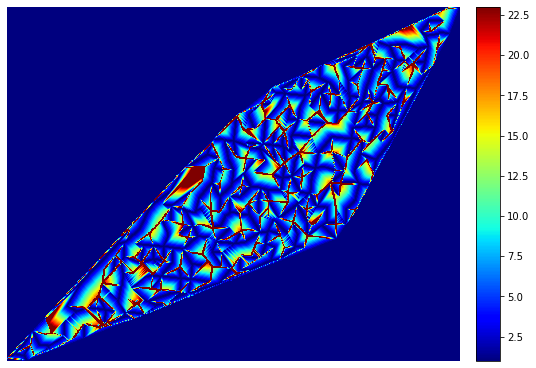

rdarray([[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 4., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]])

In [170]:
accum_d8 = rd.FlowAccumulation(sp_dem, method='D8')
d8_fig = rd.rdShow(accum_d8,figsize=(8,5.5), axes=False, cmap='jet')
accum_d8

In [171]:
accum_d8.shape

(445, 569)

In [174]:
math.log(math.e)

1.0

In [217]:
slope_l = []
accum_l = []
for point in df['geometry']:
    x = point.xy[0][0]
    y = point.xy[1][0]
    row, col = dataset.index(x,y)
    slope_l.append(slope[row,col])
    accum_l.append(accum_d8[row,col])

In [199]:
slope_l = np.array(slope_l)
accum_l = np.array(accum_l)

In [218]:
TWI = []

for i in range(len(slope_l)):
    TWI.append(np.log(accum_l[i]/ (math.tan((slope_l[i]* math.pi/180.0))+.01)))

In [3]:
data_file = pd.read_csv('filename.txt', sep=" ", header=None)
data_file.head()

0
0           AK_BrooksCamp_2012/
1              AK_Coastal_2009/
2  AK_Fairbanks-NSBorough_2010/
3               AK_Juneau_2012/
4                AK_Kenai_2008/

In [7]:
file_list = data_file[0].to_list()

['AK_BrooksCamp_2012/',
 'AK_Coastal_2009/',
 'AK_Fairbanks-NSBorough_2010/',
 'AK_Juneau_2012/',
 'AK_Kenai_2008/']

# data loading experiment

In [52]:

def create_meta(region_list, name, url, offset=0):
    metadata = {}
    urlf = ""+str(url)
    counter = 0 + offset
    for i in range(len(region_list)):
        newurl = urlf+str(region_list[i+offset])+"ept.json"
        counter = counter+1
        try:
            with open(name, 'r') as openfile:
                # Reading from json file
                metadata = json.load(openfile)
        except:
            pass
        print((newurl), counter)
        with urllib.request.urlopen(newurl, timeout=1000000) as url:
            data = json.loads(url.read().decode())
            metadata[f'{region_list[i+offset]}'] = data
        with open(name, "w") as outfile:
            outfile.write(json.dumps(metadata))

In [ ]:
def fetch_data(coordinates, polygon, pipeline, epsg=[3857, 4326], url='https://s3-us-west-2.amazonaws.com/usgs-lidar-public/'):
    coor = loop_EPSG_converter(coordinates, epsg[1], epsg[0])
    polygon = generate_polygon(coor, epsg[0])
    
    selection = compare("metadata.json", coor)
    
    print(f"Selected Regions: {selection[0]}")

    data = load_full_data(selection, url, polygon, pipeline, epsg)
    
    return data

In [130]:
def compare(meta_loc, coor):
    try:
        with open(meta_loc, 'r') as openfile:
            # Reading from json file
            metadata = json.load(openfile)
            metakeys = list(metadata.keys())
    except:
        pass
    selection_list = {}
    for i in range(len(metakeys)):
        bounds = metadata[metakeys[i]]['boundsConforming']
        xMin, yMin = float(bounds[0]), float(bounds[1])
        xMax, yMax = float(bounds[3]), float(bounds[4])
        for points in coor:
            px = float(points[0])
            py = float(points[1])
            if((px >= xMin) and (px <= xMax)):
                if((py >= yMin) and (py <= yMax)):
                    save_bounds = bounds[:]
                    save_bounds.pop(2)
                    save_bounds.pop(4)
                    selection_list[metakeys[i]] = save_bounds
       
    return [list(selection_list.keys()), list(selection_list.values())]

In [234]:
def load_full_data(selection_list, url, polygon, json_location, epsg):
    regions = selection_list[0]
    bounds = selection_list[1]
    
    data = {}
    url = url
    for i in range(len(regions)):
        try:
            year = int(regions[i][-4:])
        except ValueError:
            year = None
        region = regions[i]
        furl = url+region+"ept.json"
        request = modify_pipe_json(json_location, furl, epsg[0], epsg[1], polygon, bounds[i])
        pipe = pdal.Pipeline(json.dumps(request))
        pipe.execute()
        df = generate_geo_df(pipe.arrays[0], epsg[1])
        data["year"] = f"{year}"
        data["data"] = df
    
    return pd.DataFrame([data])
        

In [180]:
coordinates = [
    [-93.756055, 41.918115],
    [-93.756155, 41.918215],
    [-93.756396, 41.918475],
    [-93.755955, 41.918300],
    [-93.755795, 41.918000],
]

# grid interpolation experiment

In [454]:
def grid_resample(df,size, epsg=4326):
    newdf = df.copy()
    points1 = list(zip(newdf.geometry.x, newdf.geometry.y, newdf.elevation.values))
    
    voxel_size=size
    nb_vox=np.ceil((np.max(points1, axis=0) - np.min(points1, axis=0))/voxel_size)
    nb_vox
    
    non_empty_voxel_keys, inverse, nb_pts_per_voxel = np.unique(((points1 - np.min(points1, axis=0)) 
                                                                 // voxel_size).astype(int), axis=0, 
                                                                return_inverse=True, return_counts=True)
    idx_pts_vox_sorted=np.argsort(inverse)
    
    voxel_grid={}
    grid_barycenter,grid_candidate_center=[],[]
    last_seen=0
    points_new = []
    for item in points1:
        tmp = []
        for it in item:
            tmp.append(it)
        points_new.append(tmp)

    points_new = np.array(points_new)

    for idx,vox in enumerate(non_empty_voxel_keys):
        voxel_grid[tuple(vox)]= points_new[idx_pts_vox_sorted[last_seen:last_seen+nb_pts_per_voxel[idx]]]
        nval = np.mean(voxel_grid[tuple(vox)],axis=0)
        grid_barycenter.append(nval)
        grid_candidate_center.append(voxel_grid[tuple(vox)][np.linalg.norm(voxel_grid[tuple(vox)] - np.mean(voxel_grid[tuple(vox)],axis=0),axis=1).argmin()])
        last_seen+=nb_pts_per_voxel[idx]

    df22 = generate_geo_df(grid_barycenter, epsg)
    
    return df22


In [455]:
newdf = data_frame.loc[0,"data"]

In [462]:
gr_df = grid_resample(newdf, 0.000001)

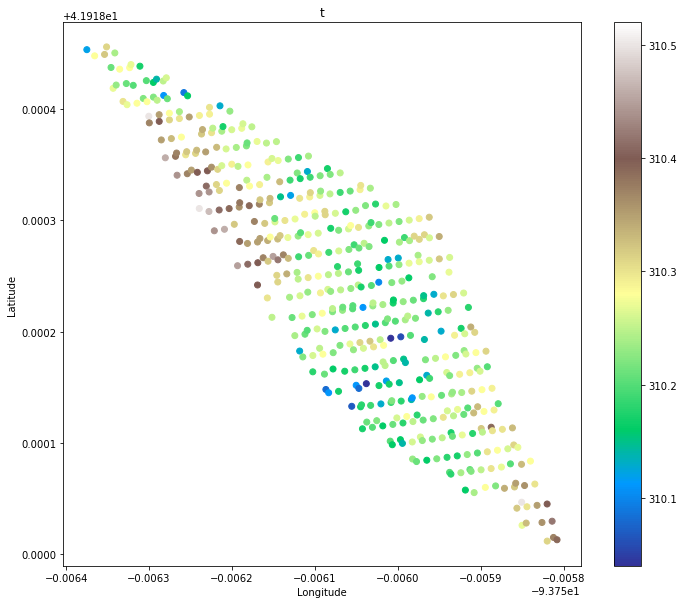

In [463]:
plot_heatmap(gr_df, "t")

# TWI experiment

In [433]:
from scipy.interpolate import griddata
from rasterio.crs import CRS
from rasterio.transform import Affine

In [449]:
def calculate_TWI(df, prec = 0.000001, epsg = 4326, save_slope=None, save_accum=None):
    in_df = df.copy()
    points = list(zip(in_df.geometry.x, in_df.geometry.y))
    values = in_df.elevation.values
    
    rRes = prec

    xRange = np.arange(newdf.geometry.x.min(), newdf.geometry.x.max()+rRes, rRes)
    yRange = np.arange(newdf.geometry.y.min(), newdf.geometry.y.max()+rRes, rRes)
    
    gridX, gridY = np.meshgrid(xRange, yRange)

    gridph = griddata(points, values, (gridX,gridY), method='cubic')
    
    transform = Affine.translation(gridX[0][0]-rRes/2, gridY[0][0]-rRes/2)*Affine.scale(rRes, rRes)
    transform
    
    rasterCrs = CRS.from_epsg(epsg)
    rasterCrs.data
    
    interpRaster = rasterio.open('raster.tif',
                             'w',
                             driver='GTiff',
                             height=gridph.shape[0],
                             width=gridph.shape[1],
                             count=1,
                             dtype=gridph.dtype,
                             crs=rasterCrs,
                             transform=transform,
                            )
    interpRaster.write(gridph,1)
    interpRaster.close()
    
    dataset = rasterio.open('raster.tif')
    
    data = dataset.read()
    
    data = np.squeeze(data)
    #data = np.nan_to_num(data, nan=-9999)
    sp_dem = rd.rdarray(data, no_data=-9999)
    
    slope = rd.TerrainAttribute(sp_dem, attrib='slope_riserun')
    if save_slope is not None:
        slope_pic = rd.rdShow(slope, axes=True, cmap='magma', figsize=(10, 5))
        plt.savefig(save_slope)
    
    accum_d8 = rd.FlowAccumulation(sp_dem, method='D8')
    if save_accum is not None:
        d8_fig = rd.rdShow(accum_d8,figsize=(10,5), axes=False, cmap='jet')
        plt.savefig(save_accum)
    
    slope_l = []
    accum_l = []
    for point in newdf['geometry']:
        x = point.xy[0][0]
        y = point.xy[1][0]
        row, col = dataset.index(x,y)
        slope_l.append(slope[row,col])
        accum_l.append(accum_d8[row,col])
        
    TWI = []

    for i in range(len(slope_l)):
        TWI.append(np.log(abs((accum_l[i]/math.tan((slope_l[i]* math.pi/180.0))))))
        
    df["TWI"] = TWI
    
    return df

In [451]:
re_df = calculate_TWI(newdf)

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0293536====================== ] (99% - 0.0s - 1 threads)

A O'Callaghan (1984)/Marks (1984) D8/D4 Flow Accumulation
C O'Callaghan, J.F., Mark, D.M., 1984. The Extraction of Drainage Networks from Digital Elevation Data. Computer vision, graphics, and image processing 28, 323--344.

c topology = D8
[================================================= ] (99% - 0.0s - 1 threads)
A Generic Flow Accumulation Algorithm
p Creating dependencies array...

d Source cells found = 186036
p Calculating flow accumulation...
t Wall-time       = 0.0593509 s============== ] (99% - 0.0s - 1 threads)


In [453]:
re_df.head(15)

elevation                    geometry        TWI
0      310.37  POINT (-93.75581 41.91802)  10.217516
1      310.33  POINT (-93.75585 41.91803)   8.948420
2      310.30  POINT (-93.75584 41.91804)   9.848519
3      310.40  POINT (-93.75582 41.91805)        NaN
4      310.24  POINT (-93.75591 41.91806)   8.908008
5      310.34  POINT (-93.75587 41.91806)   8.884058
6      310.32  POINT (-93.75586 41.91806)  11.583701
7      310.36  POINT (-93.75585 41.91806)   9.824739
8      310.22  POINT (-93.75588 41.91806)  14.476666
9      310.22  POINT (-93.75591 41.91807)  13.109168
10     310.30  POINT (-93.75589 41.91808)  10.335430
11     310.27  POINT (-93.75587 41.91808)  10.625730
12     310.33  POINT (-93.75585 41.91808)   9.345409
13     310.20  POINT (-93.75586 41.91808)  15.248700
14     310.17  POINT (-93.75593 41.91809)  14.063662